## Load things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd

import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../")
# import utils

import dimred ### library of dimension reduction
from dimred.newpipe import Elbow
from dimred.newcistern import Knob

from dimred.data.preprocess import MinMaxScalar,AvgMaxScalar,MaxAvgScalar,scaleData
from dimred.models.linear.transform import co_kurtosis,ra_kurtosis,val_kurtosis

In [53]:
from dimred.data.loader import LoadOne,LoadMPI,LoadNumpy
from dimred.flowpipe import ServicePIpe
# from dimred.data.oldloader2 import localpath__


In [59]:
from dimred.models.linear.transform import co_kurtosis,co_variance,Kurtosis
from dimred.data.preprocess import Shaper,Scalar

class Servicer:
    def __init__(self,x,moment=co_variance,scalar=AvgMaxScalar,n_retain=4) -> None:
        # self.xin = x.copy()
        self.xout = x.copy()
        self.shaper= Shaper()
        self.scalar = Scalar(scalar)
        self.model = Kurtosis(moment=moment,n_retain=n_retain)
        self.pipeline = [self.shaper,self.scalar,self.model]
        ## Todo add post processing class
    
    def encode(self):
        for p in self.pipeline:
            self.xout = p.fit_transform(self.xout)

    def decode(self,xenc):
        for p in reversed(self.pipeline):
            xenc = p.transform2(xenc)
        return xenc
        # return x
    

In [71]:
loader = LoadNumpy('oned','onedsin')

In [49]:
def get_dot(u1,u2):
    return [v1@v2 for v1,v2 in zip(u1,u2)]

def get_fmm(u1,s1):
    return (u1*s1).sum(axis=1)


In [ ]:
def make_df(arr,cols):
    df = pd.DataFrame(arr)
    df.columns = cols
    return df.T

In [64]:
def feat_comp(loader,tidx=2,Nd=4):
    gd = loader.x[tidx]
    gp = ServicePIpe(gd)

    dx = int(len(gd)/Nd)
    sdms = [gd[dx*i:dx*(i+1)] for i in range(Nd)] 
    sps = [Servicer(dm) for dm in sdms]

    temp = [p.encode() for p in sps+[gp]]
    
    fmms = [get_fmm(sp.model.u,sp.model.s) for sp in sps]
    locs = [get_dot(gp.model.u,sp.model.u) for sp in sps]

    cols = loader.varid
    return make_df(fmms,cols) ,make_df(locs,cols)   

In [79]:
def plot_time(tidx=10):
    df1,df2 = feat_comp(loader,tidx)
    fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(14,6))
    df1.plot.bar(ax=ax1)
    df2.plot.bar(ax=ax2)

In [82]:
from ipywidgets import interactive

In [83]:
interactive(plot_time,tidx=range(1,201))


interactive(children=(Dropdown(description='tidx', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<AxesSubplot:>

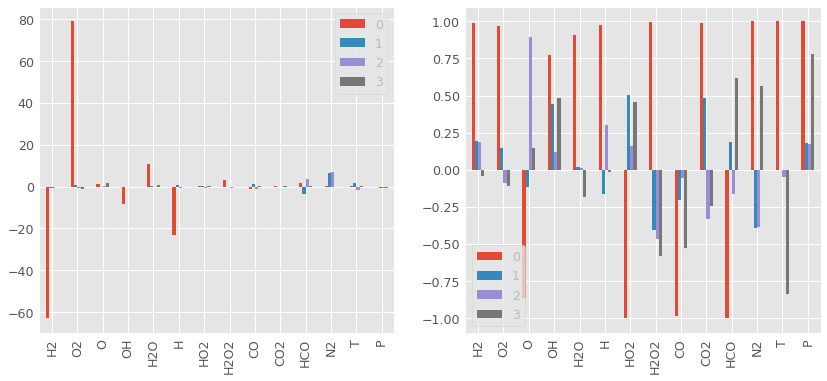

In [27]:
dots = [getDot(gp.model.u,sp.model.u) for sp in sps]

In [29]:
import pandas as pd

<AxesSubplot:>

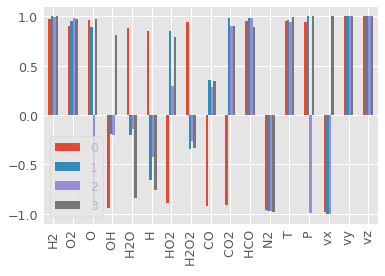

In [36]:
df = pd.DataFrame(np.array(dots))
df.columns = loader.varid
df.T.plot.bar()

In [12]:
dms[0].shape

(201, 256, 17)

In [2]:
rn = Elbow('ethane')
rn.MyScalar = MinMaxScalar

rn.mf_build(10);
# rn.mf_alldata();
topbar = Knob(rn)


FileNotFoundError: [Errno 2] No such file or directory: '/home/shubham/strial/mdimred/datasets/etha/variable.txt'

In [3]:
topbar

Average Error is 112072.8785


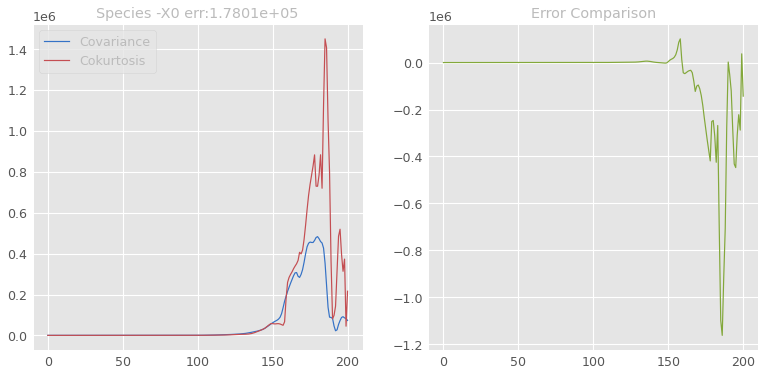

In [4]:
rn = Elbow('methane')
rn.MyScalar = MaxAvgScalar

rn.mf_build(10);
# rn.mf_alldata();
topbar = Knob(rn)


In [5]:
topbar

In [15]:
rn.loader.varid

{'H2': 0,
 ' O2': 1,
 ' O': 2,
 ' OH': 3,
 ' H2O': 4,
 ' H': 5,
 ' HO2': 6,
 ' H2O2': 7,
 ' CO': 8,
 ' CO2': 9,
 ' HCO': 10,
 ' N2': 11,
 ' T': 12,
 ' P': 13,
 ' vx': 14,
 ' vy': 15,
 ' vz': 16}